<a href="https://colab.research.google.com/github/deibyrios/Recognize-handwritten-digits/blob/master/Copy_of_hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 >Applied Machine Learning - Homework 5

## Task 1 - Multilayer perceptron with two hidden layers on iris dataset
  
Run a multilayer perceptron with two hidden layers and rectified linear nonlinearities on the iris dataset using the keras Sequential interface. 

Include code for selecting regularization strength and number of hidden units using GridSearchCV and evaluation on an independent test-set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import os
from zipfile import ZipFile

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from keras.initializers import glorot_uniform
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop, Adam, Adamax, Nadam
from keras.callbacks import EarlyStopping

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [0]:
from keras import backend as K
if K.backend() == "tensorflow":
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '':
        device_name = "None"
    print('Using TensorFlow version:', tf.__version__, ', GPU:', device_name)

Using TensorFlow version: 1.13.1 , GPU: /device:GPU:0


<h4> Let's load the iris dataset and get features and targets:

In [0]:
#from sklearn.datasets import load_iris

iris = load_iris()
feature_names = iris['feature_names']
target_names = iris['target_names']
num_features = len(feature_names)
num_classes = len(target_names)

X = iris['data']
y = iris['target']
y = keras.utils.to_categorical(y, num_classes)

print('Features: ', feature_names)
print('\nTarget Classes :', target_names)

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Target Classes : ['setosa' 'versicolor' 'virginica']


<h4> Let's split data into training and test sets:


In [0]:
#from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    stratify=y, random_state=0)
print('No. of training samples :', len(y_train), '\nNo. of test samples :',
      len(y_test))

No. of training samples : 112 
No. of test samples : 38


### Include code for selecting regularization strength and number of hidden units using GridSearchCV:

#### Let's create our keras' scikit-learn model wrapper:

In [0]:
#from keras.models import Sequential
#from keras.layers import Dense
#from keras import regularizers
#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.initializers import glorot_uniform

def make_sklearn_mlp(n_features, n_classes, l2_reg=0, hidden_units=8):
  mlp = Sequential([
    Dense(hidden_units, input_shape=(n_features,), activation='relu', 
        kernel_regularizer=regularizers.l2(l2_reg),
        kernel_initializer = glorot_uniform(0)),
    Dense(hidden_units, activation='relu',
        kernel_initializer = glorot_uniform(0)),
    Dense(n_classes, activation='softmax',
        kernel_regularizer=regularizers.l2(l2_reg),
        kernel_initializer = glorot_uniform(0))])
  mlp.compile("adam", "categorical_crossentropy", metrics=['accuracy'])
  return mlp

clf = KerasClassifier(make_sklearn_mlp, n_features=num_features,
                      n_classes=num_classes, epochs=100, batch_size=4, 
                      shuffle=True, verbose=0)
print('keras wrapper object: \n', type(clf))

keras wrapper object: 
 <class 'keras.wrappers.scikit_learn.KerasClassifier'>


#### Let's tune the regularization strength and number of hidden units using GridSearchCV:

In [0]:
#from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.model_selection import GridSearchCV

sss = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=0)

param_grid = {'l2_reg': np.logspace(-5, -3, 6),
              'hidden_units': [8, 16, 32]}

grid = GridSearchCV(clf, param_grid=param_grid, cv=sss, return_train_score=True)
grid.fit(X_train, y_train)

results = pd.DataFrame(grid.cv_results_)
results.pivot_table(index=["param_l2_reg", "param_hidden_units"],
                values=['mean_train_score', "mean_test_score"])

mean_test_score  mean_train_score
param_l2_reg param_hidden_units                                   
0.000010     8                          0.956522          0.955056
             16                         0.956522          0.977528
             32                         0.956522          0.966292
0.000025     8                          0.956522          0.966292
             16                         0.956522          0.966292
             32                         0.913043          0.966292
0.000063     8                          0.913043          0.977528
             16                         0.956522          0.988764
             32                         0.956522          0.966292
0.000158     8                          0.956522          0.977528
             16                         0.956522          0.988764
             32                         0.956522          0.977528
0.000398     8                          0.913043          0.977528
             16                         0.956522          0.977528
             32                         0.956522          0.966292
0.001000     8                          0.956522          0.977528
             16                         0.956522          0.966292
             32                         0.956522          0.966292

#### From the above, we can see that for very small regularizations, 8, 16 and 32 hidden units perform very similar so our simpler model would be 8 units with minimum regularization, which is indeed the the one returned by  'grid.best_params_':

In [0]:
print('\nBest Parameters: \n', grid.best_params_)


Best Parameters: 
 {'hidden_units': 8, 'l2_reg': 1e-05}


#### Let's train our tuned model on the entire training set (including validation ) and evaluate it on an independent test-set:

In [0]:
best_clf = grid.best_estimator_
best_clf.fit(X_train, y_train)
score = best_clf.score(X_test, y_test)
print("\nTest Accuracy: {:.3f}".format(score))

print('\nNo. of training samples :', len(y_train), '\nNo. of test samples :',
      len(y_test))


Test Accuracy: 1.000

No. of training samples : 112 
No. of test samples : 38


#### We got a test accuraccy of 100%. Though we put apart 25% of the data for test, the dataset size is only 150 samples so the test set is just 38 samples. That may be the reason why we are getting 100% accuracy as it is a very small test set.
<br><br>

## Task 2 - Multilayer perceptron on the Fashion MNIST dataset
  
Train a multilayer perceptron (fully connected) on the Fashion MNIST dataset using the traditional train/test split as given by fashion_mnist.load_data in keras. 

Use a separate 10000 samples (from the training set) for model selection and to compute learning curves (accuracy vs epochs, not vs n_samples). 

Compare a “vanilla” model with a model using drop-out (potentially a bigger model), and to a model using batch normalization and residual connections (but not dropout). Visualize learning curves for all models.

#### From the keras datasets [documentation for Fashion-MINST](https://keras.io/datasets/#fashion-mnist-database-of-fashion-articles):


#### Fashion-MNIST database of fashion articles

Dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST. 

**The class labels are:**

Label	Description

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6.	Shirt
7.	Sneaker
8.	Bag
9.	Ankle boot

#### Usage:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

#### Returns:
2 tuples:
* x_train, x_test: uint8 array of grayscale image data with shape (num_samples, 28, 28).
* y_train, y_test: uint8 array of labels (integers in range 0-9) with shape (num_samples,).

#### Let's download the data:

In [0]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [0]:
print('\nTraining data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('\nTest data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)

Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


#### Let's visualize a sample of the data:

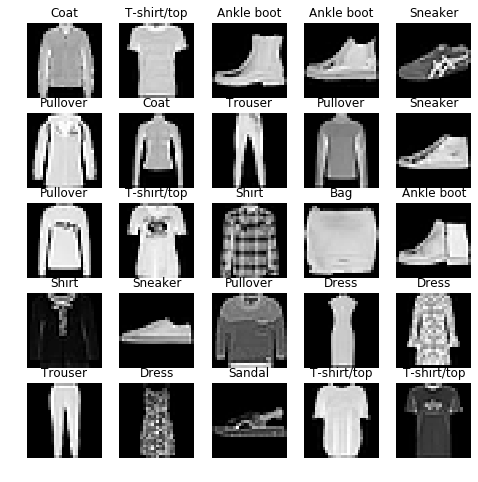

In [0]:
target_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#We randomly choose 25 images from the train dataset.
fig, axes1 = plt.subplots(5,5,figsize=(8,8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_train)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_train[i], cmap="gray")
        axes1[j][k].set_title(target_names[y_train[i]])

#### Since we will be working with a fully connected MLP, we need to flatten the features:

#### Let's flatten the features and one-hot-encode the targets:

In [0]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

num_classes = len(target_names)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('\nTraining data shape: ', X_train.shape)
print('Train data shape: ', X_train.shape)

print('\nTest data shape: ', X_test.shape)
print('Train labels shape: ', y_train.shape)

print('\nTraining features scale: ', [np.min(X_train), np.max(X_train)])


Training data shape:  (60000, 784)
Train data shape:  (60000, 784)

Test data shape:  (10000, 784)
Train labels shape:  (60000, 10)

Training features scale:  [0, 255]


#### As we can see above, the pixels are in [0, 255] scale. There is not need to normalize then, but let's just scale to [0, 1]:

In [0]:
X_train, X_test = X_train/255.0, X_test/255.0
print('\nTraining features scale: ', [np.min(X_train), np.max(X_train)])
print('Test features scale: ', [np.min(X_test), np.max(X_test)])


Training features scale:  [0.0, 1.0]
Test features scale:  [0.0, 1.0]


#### Let's separate 10,000 samples (from the training set) as holdout validation set to be used for model selection and to compute learning curves (accuracy vs epochs): 

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=10000,
                                                  stratify=y_train,
                                                  random_state=0)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Train data shape:  (50000, 784)
Train labels shape:  (50000, 10)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000, 10)


#### As additional preprocessing: let's subtract the mean value across every dimension for training data:

In [0]:
mean_image = np.mean(X_train, axis=0)
X_train = X_train - mean_image
X_val = X_val - mean_image
X_test = X_test - mean_image

num_features = X_train.shape[1]

#### Let's separate 10,000 training samples for development and initial model selection:

In [0]:
_, X_dev, _, y_dev = train_test_split(X_train, y_train,
                                                  test_size=10000,
                                                  stratify=y_train,
                                                  random_state=0)
_, X_dev_val, _, y_dev_val = train_test_split(X_test, y_test,
                                                  test_size=2500,
                                                  stratify=y_test,
                                                  random_state=0)
print('Development data shape: ', X_dev.shape)
print('Development labels shape: ', y_dev.shape)
print('Dev validation data shape: ', X_dev_val.shape)
print('Dev validation labels shape: ', y_dev_val.shape)

Development data shape:  (10000, 784)
Development labels shape:  (10000, 10)
Dev validation data shape:  (2500, 784)
Dev validation labels shape:  (2500, 10)


#### Let's create a re-utilizable function called "make_mlp", where we can define the number of layers and number of hidden units per layer, whether to use batch normalization or not, the dropout rate (0 if no dropout) and we can also specify the optimizer, learning rate and the learning rate decay. 

#### We can then just re-utilize this "make_mlp" function as needed during this task 2:

In [0]:
#from keras.optimizers import RMSprop, Adam, Adamax, Nadam

def make_mlp(n_features, n_classes, hidden_units=[4],
                     optimizer=keras.optimizers.Adam, lr=1e-3, decay=0,
                    batchnorm=True, drop=0):
  """
  Function for keras' scikit-learn classifier wrapper
  Developed by Andres Rios, dar2196, Columbia AML HW5 Spring 2019  
  :param n_features: Integer. Number of training features.
  :param n_classes: Integer. Number of classes for classification.
  :param hidden_units: List. List with number of hidden units per layer
  :param optimizer: A kers optimizer from keras.optimizers
  :param lr: Float. learning rate for the optimizer.
  :param decay: Float. learning rate decay for the optimizer.
  :param batchnorm: Boolean. True to use batchnormalization.
  :param drop: Float. Dropout rate.
  return: keras MLP classifier
  """
  keep = 1 - drop 
  mlp = Sequential()
  mlp.add(Dense(int(hidden_units[0]/keep), input_shape=(num_features,),
            kernel_initializer = glorot_uniform(0)))
  if batchnorm:
    mlp.add(BatchNormalization())
  mlp.add(Activation('relu'))
  if drop > 0:
    mlp.add(Dropout(drop, seed=0))
  if len(hidden_units) > 1:
    for i in range(1, len(hidden_units)):
        mlp.add(Dense(int(hidden_units[i]/keep),
            kernel_initializer = glorot_uniform(0)))
        if batchnorm:
          mlp.add(BatchNormalization())
        mlp.add(Activation('relu'))
        if drop > 0:
          mlp.add(Dropout(drop, seed=0))
  mlp.add(Dense(num_classes, activation='softmax',
           kernel_initializer = glorot_uniform(0)))
  if optimizer == keras.optimizers.Nadam:
    mlp.compile(optimizer(lr=lr, schedule_decay=decay),
                "categorical_crossentropy", metrics=['accuracy'])
  else:
    mlp.compile(optimizer(lr=lr, decay=decay), "categorical_crossentropy",
              metrics=['accuracy'])
  #mlp.summary()
  return mlp

#### Let's tune the number of hidden layers and the number of hidden units per layer, using the small development set only, as a pre-model selection.

#### For that purpose, let's first use our "make_mlp" function above, to create a keras' scikit-learn model wrapper where we can tune the number of layers, number of hidden units per layer and any other parameter in our "make_mlp" function or in the keras model of in the “fit” parameters:

In [0]:
clf = KerasClassifier(make_mlp, n_features=num_features,
                      n_classes=num_classes, shuffle=True, verbose=0)
print('keras wrapper object: \n', type(clf))

keras wrapper object: 
 <class 'keras.wrappers.scikit_learn.KerasClassifier'>


#### Now, let's GridSearch the number of hidden layers and the number of hidden units per layer, using the small development set only, as a pre-model selection:

In [0]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

sss = StratifiedShuffleSplit(n_splits=1, test_size=.5, random_state=0)

param_grid = {'hidden_units': [[256,256],[512,512],[256,256,256],[512,512,512],
                              [256,256,256,256,256],[512,512,512,512,512]],
             'epochs': [100],
             'batch_size': [32],
             'verbose': [0],
             'validation_data': [(X_dev_val, y_dev_val)],
             'callbacks': [callbacks]}

grid = GridSearchCV(clf, param_grid=param_grid, cv=sss, return_train_score=True)
grid.fit(X_dev, y_dev)

results = pd.DataFrame(grid.cv_results_)
results[["param_hidden_units", 'mean_train_score', "mean_test_score"]]

,param_hidden_units,mean_train_score,mean_test_score
0,"[256, 256]",0.9802,0.8426
1,"[512, 512]",0.9830,0.8436
2,"[256, 256, 256]",0.9844,0.8544
3,"[512, 512, 512]",0.9918,0.8514
4,"[256, 256, 256, 256, 256]",0.9622,0.8396
5,"[512, 512, 512, 512, 512]",0.9674,0.8428


#### From the above results, it seems the the best structure from the ones that we specified is the one with 3 hidden layers with 256 units each layer.

#### We can also see that increasing the number of layers from 3 to 5, reduced validation accuracy results instead of increasing it.



### Let's build our “vanilla” baseline model using 3 hidden layers with 256 units each:

In [0]:
mlp = make_mlp(n_features=num_features, n_classes=num_classes,
                       hidden_units=[256, 256, 256], batchnorm=False, drop=0)
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 256)               200960    
_________________________________________________________________
activation_29 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_30 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_31 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 10)                2570      
Total para

#### Let's train and validate our "vanilla" model, using the separate 10,000 samples left as holdout validation set and  compute learning curves (accuracy vs epochs):


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 155us/step - loss: 0.4514 - acc: 0.8347 - val_loss: 0.3522 - val_acc: 0.8723
Epoch 2/50
50000/50000 [==============================] - 6s 123us/step - loss: 0.3384 - acc: 0.8763 - val_loss: 0.3476 - val_acc: 0.8746
Epoch 3/50
50000/50000 [==============================] - 6s 124us/step - loss: 0.2981 - acc: 0.8889 - val_loss: 0.3580 - val_acc: 0.8756
Epoch 4/50
50000/50000 [==============================] - 6s 125us/step - loss: 0.2692 - acc: 0.8989 - val_loss: 0.3239 - val_acc: 0.8863
Epoch 5/50
50000/50000 [==============================] - 6s 124us/step - loss: 0.2452 - acc: 0.9062 - val_loss: 0.3168 - val_acc: 0.8900
Epoch 6/50
50000/50000 [==============================] - 6s 124us/step - loss: 0.2252 - acc: 0.9145 - val_loss: 0.3259 - val_acc: 0.8937
Epoch 7/50
50000/50000 [==============================] - 6s 123us/step - loss: 0.2098 - acc: 0.9216 - val_loss: 0.3492 - 

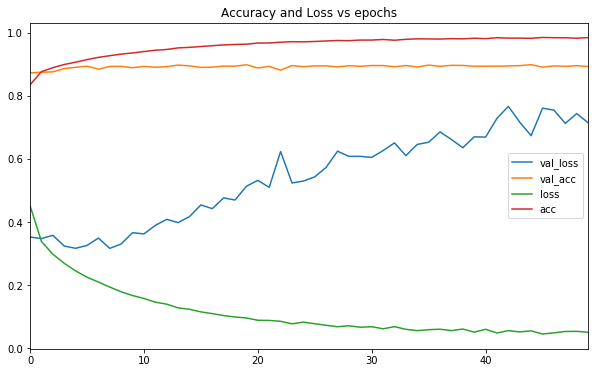

In [0]:
history_callback = mlp.fit(X_train, y_train, batch_size=32, epochs=50,
                           shuffle=True, verbose=1,
                           validation_data=(X_val, y_val))
pd.DataFrame(history_callback.history).plot(figsize=(10, 6), 
                                            title='Accuracy and Loss vs epochs')

### Let's build a model using drop-out (our  "make_mlp" function will internally increase number of units to compensate dropout rate):.

#### First, let's try dropping out rate of 10% (keep 90%):

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 284)               222940    
_________________________________________________________________
activation_32 (Activation)   (None, 284)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 284)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 284)               80940     
_________________________________________________________________
activation_33 (Activation)   (None, 284)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 284)               0         
___________________________

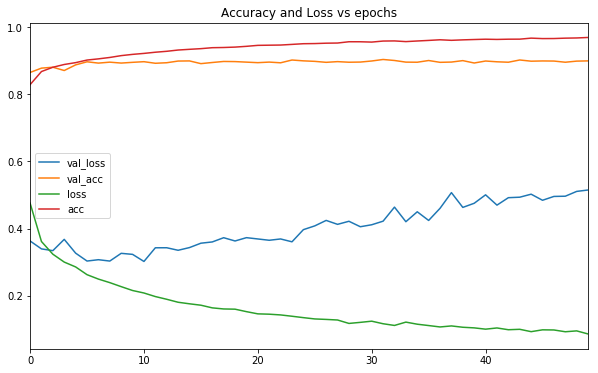

In [0]:
mlp = make_mlp(n_features=num_features, n_classes=num_classes,
                       hidden_units=[256, 256, 256], batchnorm=False, drop=0.1)
mlp.summary()
history_callback = mlp.fit(X_train, y_train, batch_size=32, epochs=50,
                           shuffle=True, verbose=1,
                           validation_data=(X_val, y_val))
pd.DataFrame(history_callback.history).plot(figsize=(10, 6), 
                                            title='Accuracy and Loss vs epochs')

#### Looking at the above results and learning curves, we can see that whithout dropout, our model was highly ovefitting while a dropout of rate of just 10% helped to regularize our model thus visibly reducing overfitting and also improved validation accuracy results.

#### Let's now try dropping out rate of 30% (keep 70%): 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 365)               286525    
_________________________________________________________________
activation_38 (Activation)   (None, 365)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 365)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 365)               133590    
_________________________________________________________________
activation_39 (Activation)   (None, 365)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 365)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 365)               133590    
__________

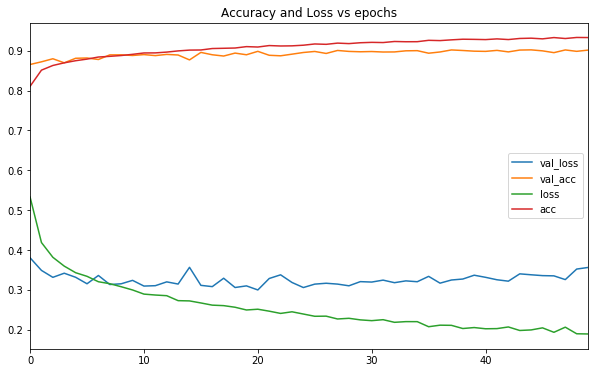

In [0]:
mlp = make_mlp(n_features=num_features, n_classes=num_classes,
                       hidden_units=[256, 256, 256], batchnorm=False, drop=0.3)
mlp.summary()
history_callback = mlp.fit(X_train, y_train, batch_size=32, epochs=50,
                           shuffle=True, verbose=1,
                           validation_data=(X_val, y_val))
pd.DataFrame(history_callback.history).plot(figsize=(10, 6), 
                                            title='Accuracy and Loss vs epochs')

#### As we can see, increasing the dropout rate from 10% to 30%, increased regularization thus reducing overfitting, even more, without decreasing validation accuracy results.

### Now, let's build a model using batch-normalization (but not dropout): 

In [0]:
mlp = make_mlp(n_features=num_features, n_classes=num_classes,
                       hidden_units=[256, 256, 256], batchnorm=True, drop=0)
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 256)               200960    
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_________________________________________________________________
activation_41 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_27 (Batc (None, 256)               1024      
_________________________________________________________________
activation_42 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 256)               65792     
__________

#### Let's train and validate our batch-normalization model:

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 280us/step - loss: 0.4791 - acc: 0.8266 - val_loss: 0.3535 - val_acc: 0.8697
Epoch 2/50
50000/50000 [==============================] - 13s 250us/step - loss: 0.3690 - acc: 0.8636 - val_loss: 0.3354 - val_acc: 0.8759
Epoch 3/50
50000/50000 [==============================] - 13s 250us/step - loss: 0.3293 - acc: 0.8772 - val_loss: 0.3150 - val_acc: 0.8838
Epoch 4/50
50000/50000 [==============================] - 12s 234us/step - loss: 0.3021 - acc: 0.8870 - val_loss: 0.3192 - val_acc: 0.8848
Epoch 5/50
50000/50000 [==============================] - 13s 260us/step - loss: 0.2831 - acc: 0.8935 - val_loss: 0.3103 - val_acc: 0.8888
Epoch 6/50
50000/50000 [==============================] - 12s 242us/step - loss: 0.2632 - acc: 0.8997 - val_loss: 0.2987 - val_acc: 0.8928
Epoch 7/50
50000/50000 [==============================] - 12s 240us/step - loss: 0.2481 - acc: 0.9068 - val_loss: 0.

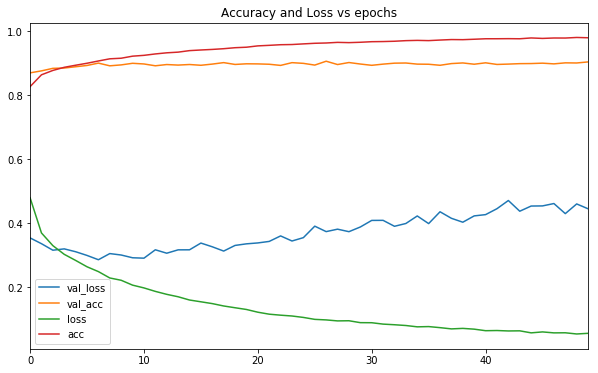

In [0]:
history_callback = mlp.fit(X_train, y_train, batch_size=32, epochs=50,
                           shuffle=True, verbose=1,
                           validation_data=(X_val, y_val))
pd.DataFrame(history_callback.history).plot(figsize=(10, 6), 
                                            title='Accuracy and Loss vs epochs')

#### Looking at the above results and learning curves, we can see that, similarly to using a dropout rate of 10%, when compared to our 'vanilla' model, batch-normalization helped to regularize our model thus reducing overfitting and also improved validation accuracy results.

### Now, let's build the same 3-layers model, using both batch normalization and residual connections (but not dropout):

In [0]:
#from keras.models import Model
#from keras.layers import Input

inputs = Input(shape=(num_features,))

res = Dense(256, kernel_initializer = glorot_uniform(0))(inputs)
bn = BatchNormalization()(res)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
bn = BatchNormalization()(dense)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
add = keras.layers.add([res, dense])
bn = BatchNormalization()(add)
relu = Activation("relu")(bn)

out = Dense(num_classes, activation='softmax')(relu)

mlp = Model(inputs=inputs, outputs=out)
mlp.compile("adam", "categorical_crossentropy", metrics=['accuracy'])

mlp.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_58 (Dense)                (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 256)          1024        dense_58[0][0]                   
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 256)          0           batch_normalization_29[0][0]     
__________________________________________________________________________________________________
dense_59 (

#### Let's train and validate our batch-normalization and residual connections model:

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 289us/step - loss: 0.4678 - acc: 0.8296 - val_loss: 0.3646 - val_acc: 0.8647
Epoch 2/50
50000/50000 [==============================] - 13s 263us/step - loss: 0.3600 - acc: 0.8676 - val_loss: 0.3288 - val_acc: 0.8801
Epoch 3/50
50000/50000 [==============================] - 12s 235us/step - loss: 0.3219 - acc: 0.8807 - val_loss: 0.3151 - val_acc: 0.8846
Epoch 4/50
50000/50000 [==============================] - 13s 269us/step - loss: 0.2934 - acc: 0.8910 - val_loss: 0.3058 - val_acc: 0.8904
Epoch 5/50
50000/50000 [==============================] - 12s 235us/step - loss: 0.2750 - acc: 0.8959 - val_loss: 0.2923 - val_acc: 0.8916
Epoch 6/50
50000/50000 [==============================] - 12s 235us/step - loss: 0.2528 - acc: 0.9046 - val_loss: 0.2902 - val_acc: 0.8965
Epoch 7/50
50000/50000 [==============================] - 13s 252us/step - loss: 0.2390 - acc: 0.9097 - val_loss: 0.

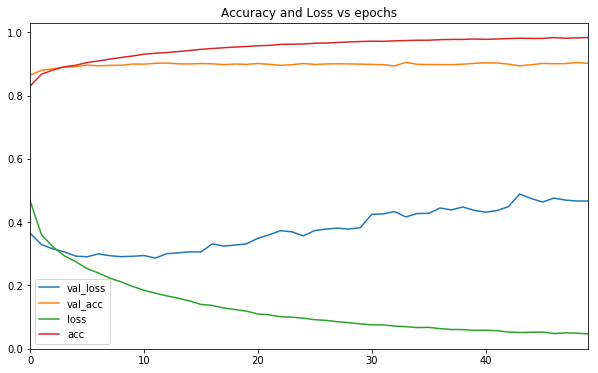

In [0]:
history_callback = mlp.fit(X_train, y_train, batch_size=32, epochs=50,
                           shuffle=True, verbose=1,
                           validation_data=(X_val, y_val))
pd.DataFrame(history_callback.history).plot(figsize=(10, 6), 
                                            title='Accuracy and Loss vs epochs')

#### Looking at the above results and learning curves, we can see that, using batch-normalization and residual connections on the  same 3-layers model, produced basically the same results that we obtained either with dropout or with batch-normalization (but no dropout).

#### However, as we showed above during the initial/pre model selection, when we tried to use a deeper network going from 3-layers to just-5 layers, decreased validation accuracy.

#### Let's now try a deeper network with 7-layers and see if the residual connections allow us to sucessfully train deeper networks:

In [0]:
inputs = Input(shape=(num_features,))

res = Dense(256, kernel_initializer = glorot_uniform(0))(inputs)
bn = BatchNormalization()(res)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
bn = BatchNormalization()(dense)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
add_1 = keras.layers.add([res, dense])
bn = BatchNormalization()(add_1)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
bn = BatchNormalization()(dense)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
add_2 = keras.layers.add([add_1, dense])
bn = BatchNormalization()(add_2)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
bn = BatchNormalization()(dense)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
add_3 = keras.layers.add([add_2, dense])
bn = BatchNormalization()(add_3)
relu = Activation("relu")(bn)

out = Dense(num_classes, activation='softmax')(relu)

mlp = Model(inputs=inputs, outputs=out)
mlp.compile("adam", "categorical_crossentropy", metrics=['accuracy'])

mlp.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_62 (Dense)                (None, 256)          200960      input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 256)          1024        dense_62[0][0]                   
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 256)          0           batch_normalization_32[0][0]     
__________________________________________________________________________________________________
dense_63 (

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 25s 495us/step - loss: 0.4941 - acc: 0.8208 - val_loss: 0.3538 - val_acc: 0.8711
Epoch 2/50
50000/50000 [==============================] - 21s 425us/step - loss: 0.3765 - acc: 0.8606 - val_loss: 0.3440 - val_acc: 0.8734
Epoch 3/50
50000/50000 [==============================] - 24s 473us/step - loss: 0.3383 - acc: 0.8743 - val_loss: 0.3190 - val_acc: 0.8849
Epoch 4/50
50000/50000 [==============================] - 23s 462us/step - loss: 0.3091 - acc: 0.8843 - val_loss: 0.2964 - val_acc: 0.8903
Epoch 5/50
50000/50000 [==============================] - 22s 447us/step - loss: 0.2897 - acc: 0.8916 - val_loss: 0.3254 - val_acc: 0.8814
Epoch 6/50
50000/50000 [==============================] - 23s 469us/step - loss: 0.2691 - acc: 0.8981 - val_loss: 0.2967 - val_acc: 0.8907
Epoch 7/50
50000/50000 [==============================] - 21s 426us/step - loss: 0.2524 - acc: 0.9039 - val_loss: 0.

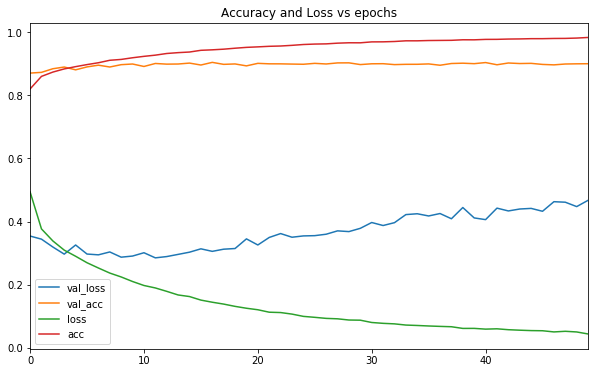

In [0]:
history_callback = mlp.fit(X_train, y_train, batch_size=32, epochs=50,
                           shuffle=True, verbose=1,
                           validation_data=(X_val, y_val))
pd.DataFrame(history_callback.history).plot(figsize=(10, 6), 
                                            title='Accuracy and Loss vs epochs')

#### As we can see above, on this deeper network using residual connections, we were able to get the same performance than best previous models.

#### Now let's see what results we get if we try exactly the same deep network but with no residual connections:

In [0]:
inputs = Input(shape=(num_features,))

dense = Dense(256, kernel_initializer = glorot_uniform(0))(inputs)
bn = BatchNormalization()(dense)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
bn = BatchNormalization()(dense)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
bn = BatchNormalization()(dense)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
bn = BatchNormalization()(dense)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
bn = BatchNormalization()(dense)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
bn = BatchNormalization()(dense)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
bn = BatchNormalization()(dense)
relu = Activation("relu")(bn)

out = Dense(num_classes, activation='softmax')(relu)

mlp = Model(inputs=inputs, outputs=out)
mlp.compile("adam", "categorical_crossentropy", metrics=['accuracy'])

mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 256)               200960    
_________________________________________________________________
batch_normalization_56 (Batc (None, 256)               1024      
_________________________________________________________________
activation_71 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_57 (Batc (None, 256)               1024      
_________________________________________________________________
activation_72 (Activation)   (None, 256)               0         
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 27s 547us/step - loss: 0.5577 - acc: 0.8044 - val_loss: 0.3800 - val_acc: 0.8620
Epoch 2/50
50000/50000 [==============================] - 22s 438us/step - loss: 0.4273 - acc: 0.8463 - val_loss: 0.4262 - val_acc: 0.8406
Epoch 3/50
50000/50000 [==============================] - 24s 480us/step - loss: 0.3861 - acc: 0.8616 - val_loss: 0.3472 - val_acc: 0.8757
Epoch 4/50
50000/50000 [==============================] - 23s 457us/step - loss: 0.3576 - acc: 0.8696 - val_loss: 0.3316 - val_acc: 0.8815
Epoch 5/50
50000/50000 [==============================] - 23s 456us/step - loss: 0.3394 - acc: 0.8761 - val_loss: 0.3359 - val_acc: 0.8794
Epoch 6/50
50000/50000 [==============================] - 22s 444us/step - loss: 0.3158 - acc: 0.8861 - val_loss: 0.3040 - val_acc: 0.8917
Epoch 7/50
50000/50000 [==============================] - 23s 463us/step - loss: 0.2986 - acc: 0.8899 - val_loss: 0.

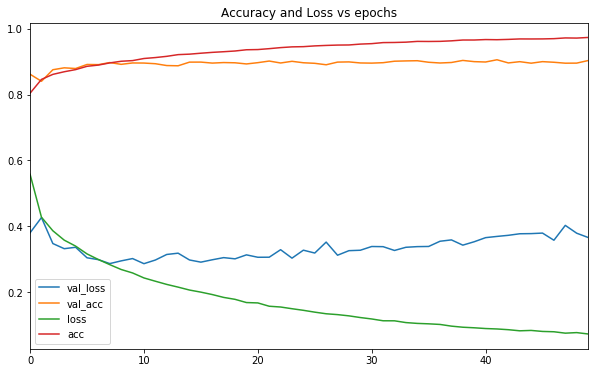

In [0]:
history_callback = mlp.fit(X_train, y_train, batch_size=32, epochs=50,
                           shuffle=True, verbose=1,
                           validation_data=(X_val, y_val))
pd.DataFrame(history_callback.history).plot(figsize=(10, 6), 
                                            title='Accuracy and Loss vs epochs')

#### Though we were expecting worse results on this 7-layers network without using residual connections, as we can see above, we were able to get basically the same results. This may be due to the fact that the network is not deep enought and we are still using batch-normalization.  

#### As a last thing, let's train the 7-layers network with batch-normalization and residual connections using early termination and evaluate it using the test set that we haven't looked until now: 

In [0]:
inputs = Input(shape=(num_features,))

res = Dense(256, kernel_initializer = glorot_uniform(0))(inputs)
bn = BatchNormalization()(res)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
bn = BatchNormalization()(dense)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
add_1 = keras.layers.add([res, dense])
bn = BatchNormalization()(add_1)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
bn = BatchNormalization()(dense)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
add_2 = keras.layers.add([add_1, dense])
bn = BatchNormalization()(add_2)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
bn = BatchNormalization()(dense)
relu = Activation("relu")(bn)

dense = Dense(256, kernel_initializer = glorot_uniform(0))(relu)
add_3 = keras.layers.add([add_2, dense])
bn = BatchNormalization()(add_3)
relu = Activation("relu")(bn)

out = Dense(num_classes, activation='softmax')(relu)

mlp = Model(inputs=inputs, outputs=out)
mlp.compile("adam", "categorical_crossentropy", metrics=['accuracy'])

mlp.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 784)          0                                            
__________________________________________________________________________________________________
dense_122 (Dense)               (None, 256)          200960      input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 256)          1024        dense_122[0][0]                  
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 256)          0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
dense_123 

In [0]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15)]

history_callback = mlp.fit(X_train, y_train, batch_size=32, epochs=50,
                           shuffle=True, verbose=0,
                           validation_data=(X_val, y_val),
                           callbacks = callbacks)

score = mlp.evaluate(X_test, y_test, verbose=0)
print("Test loss: {:.3f}".format(score[0]))
print("Test Accuracy: {:.3f}".format(score[1]))

Test loss: 0.452
Test Accuracy: 0.899


#### As we can see above, we got a test accuracy of ≈ 90%, nothing bad for a fully connected network or MLP, which is not the ideal model for image classification and is very far in complexity than the state of the art models. 

<h2> Task 3 - Train a convolutional neural network
  
 <h3>  Let's perform all necessary steps to download the dataset from Kaggle into Google's Colab, using Kaggle CLI:

In [0]:
# Install Kaggle CLI:
!pip install kaggle

In [0]:
# Authorize Colab to access Kagle by importing kaggle.json from google drive:
# This snippet will output a link which needs authentication from google account
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


#### List all Kaggle datasets with the keyword 'Histopathology':

In [0]:
!kaggle datasets list -s Histopathology

ref                                             title                            size  lastUpdated          downloadCount  
----------------------------------------------  -------------------------------  ----  -------------------  -------------  
paultimothymooney/breast-histopathology-images  Breast Histopathology Images      1GB  2017-12-19 05:46:40           4496  
kmader/skin-cancer-mnist-ham10000               Skin Cancer MNIST: HAM10000       3GB  2018-09-20 20:36:13           7803  
tywangty/histopathologiccancerwsi               histopathologic-cancer-WSI        5MB  2019-03-14 13:21:16             27  
discdiver/mnist1000-with-one-image-folder       MNIST1000_with_one_image_folder   3GB  2019-03-20 17:30:54             28  


#### Download the dataset to Google's Colab:

In [0]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

 99% 1.48G/1.49G [00:27<00:00, 67.9MB/s]
100% 1.49G/1.49G [00:27<00:00, 58.2MB/s]


#### Let's check the name of the dowloaded file:

In [0]:
#import os

os.listdir()

['.config', 'breast-histopathology-images.zip', 'adc.json', 'sample_data']

#### Let's unzip 'breast-histopathology-images.zip' and check unzipped files:

In [0]:
!unzip breast-histopathology-images.zip
os.remove('breast-histopathology-images.zip')
os.listdir()

Archive:  breast-histopathology-images.zip
  inflating: IDC_regular_ps50_idx5.zip  


['.config', 'adc.json', 'IDC_regular_ps50_idx5.zip', 'sample_data']

#### Let's unzip 'IDC_regular_ps50_idx5.zip' into a folder named 'data':

In [0]:
#from zipfile import ZipFile 
  
file_name = 'IDC_regular_ps50_idx5.zip'
with ZipFile(file_name, 'r') as zip: 
    print('Unzipping...') 
    zip.extractall('data') 
    print('Done Unzipping!') 
os.remove('IDC_regular_ps50_idx5.zip')
os.listdir()

Unzipping...
Done Unzipping!


['.config', 'adc.json', 'data', 'sample_data']

#### Let's check the content of the 'data' Dir: 

In [0]:
os.listdir('./data')

['12876',
 '12821',
 '12873',
 '9325',
 '9083',
 '12826',
 '15473',
 '12811',
 '10301',
 '10302',
 '13023',
 '15634',
 '8863',
 '8951',
 '9266',
 '8975',
 '10253',
 '9254',
 '14189',
 '15471',
 '14304',
 '9320',
 '13691',
 '12910',
 '10278',
 '9382',
 '12929',
 '9073',
 '9265',
 '12869',
 '12897',
 '9125',
 '16166',
 '14188',
 '12823',
 '13689',
 '9262',
 '16165',
 '9126',
 '14190',
 '10254',
 '16551',
 '10282',
 '8914',
 '9175',
 '9346',
 '16895',
 '10293',
 '12934',
 '13024',
 '12907',
 '12955',
 '13019',
 '9258',
 '10276',
 '12884',
 '12820',
 '8955',
 '12242',
 '13613',
 '16569',
 '9256',
 '9029',
 '10288',
 '12948',
 '9259',
 '13692',
 '16552',
 '12877',
 '14321',
 '16554',
 '12824',
 '9176',
 '10279',
 '12810',
 '9022',
 '12932',
 '16532',
 '13616',
 '12909',
 '14078',
 '14211',
 '10291',
 '9255',
 '14081',
 '12931',
 '10308',
 '12900',
 '10286',
 '16570',
 '9173',
 '14154',
 '8950',
 '13106',
 '8984',
 '15514',
 '9177',
 '12949',
 '13025',
 '12875',
 '16167',
 '10307',
 '14306',

#### There are several folders. According to the metadata, each folder would correspond to a patient ID.

#### Inside each patient ID's folder, there are 2 sub-folders named '0'  and '1', where '0' stores the images with no IDC (I'nvasive Ductal Carcinoma' breast cancer) and '1' stores images with IDC:

In [0]:
os.listdir('./data/12810')

['1', '0']

In [0]:
print('\nFirst five (5) non-IDC images for patient ID ¨12810¨:')
for img in os.listdir('./data/12810/0')[:5]:
  print('  *', img)

print('\nFirst five (5) IDC images for patient ID ¨12810¨:')
for img in os.listdir('./data/12810/1')[:5]:
  print('  *', img)


First five (5) non-IDC images for patient ID ¨12810¨:
  * 12810_idx5_x2501_y1501_class0.png
  * 12810_idx5_x1451_y2651_class0.png
  * 12810_idx5_x2151_y201_class0.png
  * 12810_idx5_x951_y1201_class0.png
  * 12810_idx5_x1551_y2501_class0.png

First five (5) IDC images for patient ID ¨12810¨:
  * 12810_idx5_x1851_y1151_class1.png
  * 12810_idx5_x1651_y1101_class1.png
  * 12810_idx5_x1601_y651_class1.png
  * 12810_idx5_x1001_y1151_class1.png
  * 12810_idx5_x1501_y1251_class1.png


In [0]:
from urllib.request import urlretrieve
import os

def download(url, file):
    if not os.path.isfile(file):
        print("Download file... " + file + " ...")
        urlretrieve(url,file)
        print("File downloaded")

download('https://www.kaggle.com/paultimothymooney/breast-histopathology-images/downloads/breast-histopathology-images.zip/1','breast_cancer2.zip')

try:
  os.system('7z x breast_cancer.zip')
except Exception as e:
  print(e)

In [0]:
try:
  !7z e breast_cancer.zip
  print('unnzipped')
  
except Exception as e:
  print(e)

#### Let's plot to see if there is any visually preceptible one-to-one relationship between the target and the newly derived features:

In [0]:
os.system( '7z x breast_cancer.zip -oPath/to/Name' )

#### It seems like these newly derived features do not encode much information about the target. Let's add them as additional features to our base model and see it it performs better:

In [0]:
X_train = bag.fit_transform(text_train)
X_train

In [0]:
new_features = df[new_cols]
X_train = hstack((X_train, new_features))
X_train

### Let's evaluate our baseline model with these newly added features:

In [0]:
lr = LogisticRegressionCV(scoring="roc_auc", random_state=0).fit(X_train, y_train)
auc_roc_derived_features = lr.scores_[1].mean(axis=0).max()
print ('\nMax auc_roc baseline model: {:.8f}'.format(auc_roc_baseline))
print ('Max auc_roc with newly derived features: {:.8f}'.format(auc_roc_derived_features))

#### Result didn't improve. 

### Let's now explore some other features we think may be important for this speficic task:

In [0]:
some_bad_strings = ['shit','fuck','dam','mother','father','dad','hate','sex'] # strings in bad words
offense_words = ['you','your','they','their','our','ours','mom', 'comment'] # frequently used in offensive responses

bad_words = lambda x: len([word for bad in some_bad_strings for word in x['body'].split() if bad in str.lower(word)])
offensive = lambda x: len([word for offense in offense_words for word in x['body'].split() if offense == str.lower(word)])

df = df[['body', 'REMOVED']]
df['bad_words'] = df.apply(bad_words, axis=1)
df['offensive'] = df.apply(offensive, axis=1)
print(df[:20])

#### Let's add these newly derived features to our base model and see it it performs better:

In [0]:
X_train = bag.fit_transform(text_train)
X_train

In [0]:
new_cols = ['bad_words', 'offensive']
new_features = df[new_cols]
X_train = hstack((X_train, new_features))
X_train

In [0]:
lr = LogisticRegressionCV(scoring="roc_auc", random_state=0).fit(X_train, y_train)
auc_roc_derived_features = lr.scores_[1].mean(axis=0).max()
print ('\nMax auc_roc baseline model: {:.8f}'.format(auc_roc_baseline))
print ('Max auc_roc with newly derived features: {:.8f}'.format(auc_roc_derived_features))

#### It worked this time!

#### Though a very small improvement, we can see that adding the count of bad words and words we think are frequently used in offensive responses, slightly increases the performance of our classifier, using the same random state. 

<h2 >Task 2 - Word Vectors

### Use a pretrained word-embedding (word2vec, glove or fasttext) instead of the bag-of-words model.

#### Let's use Google's Word2Vect pre-trained model:

In [0]:
import gensim as gensim

W2V = gensim.models.KeyedVectors.load_word2vec_format('./Models/GoogleNews-vectors-negative300.bin', binary=True)

#### Let's get each document in our training dataset as a list of tokens for W2V model: 

In [0]:
vect_w2v = CountVectorizer(vocabulary=W2V.index2word)
vect_w2v.fit(text_train)
docs = vect_w2v.inverse_transform(vect_w2v.transform(text_train))
docs[0]

#### Now for each document, we will replace each tokens in the document by a 300-dimensional vector, then represent each document by the mean of all the 300-dimensional vectors:

In [0]:
try:
    X_train = np.vstack([np.mean(W2V[doc], axis=0) for doc in docs])
    X_train.shape
except Exception as e:
    print('Got error/exception:', e)

#### We are getting an error: Let's see what is going on in the docs where we are getting that error:

In [0]:
removed = 0
non_removed = 0
for i in range (len(docs)):
    try:
        W2V[docs[i]]
    except Exception as e:
        if df['REMOVED'][i] == True:
            removed+=1
        else: non_removed+=1    
        print(i, text_train[i], 'REMOVED?:', df['REMOVED'][i])
print('\nn_removed: {},  n_non_removed: {}'.format(removed, non_removed))

#### As we can see above, the error is taking place in documents wehre there is not a single recognizable word (not a single word that makes sense). So let's replace all those documents with the token 'UNK': 

In [0]:
text_train_repaired = []   
for i in range (len(docs)):
    try:
        W2V[docs[i]]
        text_train_repaired.append(text_train[i])
    except Exception as e:
        text_train_repaired.append('UNK')

#### Let's go back and get each document in our repaired training dataset as a list of tokens for W2V model: 

In [0]:
vect_w2v = CountVectorizer(vocabulary=W2V.index2word)
vect_w2v.fit(text_train_repaired)
docs = vect_w2v.inverse_transform(vect_w2v.transform(text_train_repaired))
docs[0]

#### Now for each document, we will replace each tokens in the document by a 300-dimensional vector, then represent each document by the mean of all the 300-dimensional vectors (should work this time):

In [0]:
X_train = np.vstack([np.mean(W2V[doc], axis=0) for doc in docs])
X_train.shape

#### It worked!

#### Let's now see what results we get using the pretrained word2vec as compared with the baseline bag-of-words model:

In [0]:
lr = LogisticRegressionCV(scoring="roc_auc", random_state=0).fit(X_train, y_train)
auc_roc_w2v = lr.scores_[1].mean(axis=0).max()
print ('\nMax auc_roc baseline bag-of-words model : {:.8f}'.format(auc_roc_baseline))
print ('\nOur best model auc_roc (using character n-grams): {:.8f}'.format(auc_roc_char_ngrams))
print ('\nMax auc_roc using pretrained word2vec: {:.8f}'.format(auc_roc_w2v))

### Does this improve classification?

Using a a pretrained word-embedding (word2vec) instead of the bag-of-words model didn't improve classification but we got an auc_roc of 0.7279, somewhat close to our baseline bag-of-words mode where we got an auc_roc of 0.7593, though far from our best result using character n-grams with an auc_roc of 0.7915